In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import bidi.algorithm
import arabic_reshaper
import adhtools.utils

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final/topicmodelling/fiqh-light10-20/'

In [3]:
df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_light10_topics_20_labeled.csv'), index_col=0).fillna('')

In [12]:
df_topics['label'] = df_topics[['topic_level1', 'topic_level2']].apply(lambda r: ' - '.join([s for s in r if s!='']), axis=1)
df_topics

,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,label
topic_nr,,,,,,,,,,,,,
0,عقد,فل,عد,ولد,اذ,مهر,ام,نكاح,ول,زوج,personal law,marriage,personal law - marriage
1,اخذ,اذ,وقف,خمس,عشر,حول,صدق,ول,مال,زكا,ritual,aims-giving,ritual - aims-giving
2,سجد,سلام,ركع,وقت,اول,صل,ول,اذ,امام,صلا,ritual,prayer,ritual - prayer
3,امام,فل,اهل,قطع,اسلام,اذ,قتل,حد,مسلم,ول,criminal law,punishments,criminal law - punishments
4,خيار,مال,بااع,عقد,ول,قبض,اذ,ثمن,مشتر,بيع,contracts,sales,contracts - sales
5,ول,ظاهر,عدم,هذ,بخلاف,ام,اذ,فل,ذكر,اول,noise,,noise
6,طهار,مسح,حيض,دم,نجاس,اذ,صلا,وض,ول,غسل,ritual,purity,ritual - purity
7,شافع,ابو,رجل,نب,حديث,مالك,عمر,رسول,اب,صل,transmission,prophetic hadith and early legal authorities,transmission - prophetic hadith and early lega...
8,ذكر,صحيح,اب,ظاهر,اول,اخبار,شيخ,روا,هذ,سلام,transmission,general,transmission - general


In [13]:
document_topics = pd.read_csv(os.path.join(fpath, 'fiqh_light10_document_topics_20.csv'), index_col=0).sort_index()
#df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_roots_topics_20.csv'), index_col=0)
metadata = pd.read_csv(os.path.join(fpath, '../metadata-chapters.csv'), index_col=0)

In [14]:
topic_names = df_topics['label']

In [15]:
def split_fname(fname):
    splitted = fname.split('-')
    bookname = splitted[0]
    if len(splitted)>1:
        chapter = int(splitted[-1].split('.')[0])
    else:
        chapter = 0
    return (bookname, chapter)

In [16]:
document_topics.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0179MalikIbnAnas.Muwatta-00000.xml,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.220000,0.020000,0.020000,0.020000,0.220000,0.220000,0.020000,0.020000
0179MalikIbnAnas.Muwatta-00001.xml,0.000258,0.000258,0.000258,0.000258,0.000258,0.015762,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.633333,0.000258,0.000258,0.000258,0.000258,0.346512,0.000258,0.000258
0179MalikIbnAnas.Muwatta-00002.xml,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.001818,0.020000,0.001818,0.001818,0.001818,0.765455,0.001818,0.001818,0.001818,0.038182,0.147273,0.001818,0.001818
0179MalikIbnAnas.Muwatta-00003.xml,0.001724,0.001724,0.001724,0.018966,0.001724,0.001724,0.001724,0.001724,0.001724,0.018966,0.001724,0.001724,0.536207,0.001724,0.001724,0.001724,0.001724,0.398276,0.001724,0.001724
0179MalikIbnAnas.Muwatta-00004.xml,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.000680,0.531293,0.000680,0.000680,0.000680,0.000680,0.456463,0.000680,0.000680


In [17]:
metadata['filename'] = metadata.filename.astype(str)

In [18]:
metadata_newind = metadata
metadata_newind.index = pd.MultiIndex.from_tuples(metadata.filename.map(split_fname))

In [19]:
ind = metadata_newind.index
book_names = sorted(ind.levels[0])

In [20]:
largest_topics = pd.DataFrame(document_topics.idxmax(axis=1))#, index=metadata_newind.index)
largest_topics.index = metadata_newind.index

largest_topics = pd.concat((largest_topics,  metadata_newind['ChapterLength'], metadata_newind['Number_of_tokens']), axis=1)

#largest_topics.index = new_ind
largest_topics = largest_topics.reset_index()
largest_topics.columns = ['book', 'chapter', 'topic', 'length', 'total_length']

In [21]:
book_dict = {b: i for i,b in enumerate(book_names)}

In [22]:
metadata_newind['topic'] = largest_topics.set_index(['book', 'chapter'])['topic']
metadata_newind['topic_name'] = [topic_names[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level1'] = [df_topics.topic_level1[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level2'] = [df_topics.topic_level2[int(topic)] for topic in metadata_newind['topic']]

In [23]:
metadata_newind.head()

All_tokens_per-century    AuthorAKA AuthorBORNC  \
0179MalikIbnAnas.Muwatta 0                     NaN  مالك بن أنس         711   
                         1                     NaN  مالك بن أنس         711   
                         2                     NaN  مالك بن أنس         711   
                         3                     NaN  مالك بن أنس         711   
                         4                     NaN  مالك بن أنس         711   

                           AuthorBORNH AuthorDIEDC  AuthorDIEDH  \
0179MalikIbnAnas.Muwatta 0          93         795        179.0   
                         1          93         795        179.0   
                         2          93         795        179.0   
                         3          93         795        179.0   
                         4          93         795        179.0   

                                                            AuthorNAME  \
0179MalikIbnAnas.Muwatta 0  مالك بن أنس بن مالك بن عامر الأصبحي المدني   
                         1  مالك بن أنس بن مالك بن عامر الأصبحي المدني   
                         2  مالك بن أنس بن مالك بن عامر الأصبحي المدني   
                         3  مالك بن أنس بن مالك بن عامر الأصبحي المدني   
                         4  مالك بن أنس بن مالك بن عامر الأصبحي المدني   

                           Author_Geographical_Area BookSUBJ  \
0179MalikIbnAnas.Muwatta 0         Fertile Crescent    مالكي   
                         1         Fertile Crescent    مالكي   
                         2         Fertile Crescent    مالكي   
                         3         Fertile Crescent    مالكي   
                         4         Fertile Crescent    مالكي   

                                                        BookSource  \
0179MalikIbnAnas.Muwatta 0  http://shamela.ws/index.php/book/28107   
                         1  http://shamela.ws/index.php/book/28107   
                         2  http://shamela.ws/index.php/book/28107   
                         3  http://shamela.ws/index.php/book/28107   
                         4  http://shamela.ws/index.php/book/28107   

                               ...      ChapterLength       Level1Title  \
0179MalikIbnAnas.Muwatta 0     ...                  3  كتاب وقوت الصلاة   
                         1     ...                662  كتاب وقوت الصلاة   
                         2     ...                 84  كتاب وقوت الصلاة   
                         3     ...                105  كتاب وقوت الصلاة   
                         4     ...                261  كتاب وقوت الصلاة   

                                                                  Level2Title  \
0179MalikIbnAnas.Muwatta 0                                                  -   
                         1                                    باب وقوت الصلاة   
                         2                                     باب وقت الجمعة   
                         3                                             باب من   
                         4  باب ما جاء في دلوك الشمس وغسق الليل حدثني يحيى عن   

                           Number_of_tokens  \
0179MalikIbnAnas.Muwatta 0         151424.0   
                         1         151424.0   
                         2         151424.0   
                         3         151424.0   
                         4         151424.0   

                                                                 Tagging  \
0179MalikIbnAnas.Muwatta 0  Books ### | Chapters ### ||  Quran @QB@ @QE@   
                         1  Books ### | Chapters ### ||  Quran @QB@ @QE@   
                         2  Books ### | Chapters ### ||  Quran @QB@ @QE@   
                         3  Books ### | Chapters ### ||  Quran @QB@ @QE@   
                         4  Books ### | Chapters ### ||  Quran @QB@ @QE@   

                                                      filename topic  \
0179MalikIbnAnas.Muwatta 0  0179MalikIbnAnas.Muwatta-00000.xml    12   
                         1  0179MalikIbnAnas.Muwatta-00001.xml    12   
     

In [24]:
metadata_newind.to_csv(os.path.join(fpath, 'chapters_metadata_topics.csv'))

In [25]:
largest_topics['x1'] = largest_topics.groupby('book')['length'].transform(pd.Series.cumsum)
largest_topics['x0'] = largest_topics['x1'] - largest_topics['length']

In [26]:
largest_topics['total_length'] = largest_topics.groupby('book')['x1'].transform(lambda l: [l.max()]*len(l))

In [27]:
largest_topics['perc0'] = largest_topics['x0'] / largest_topics['total_length']
largest_topics['perc1'] = largest_topics['x1'] / largest_topics['total_length']

In [60]:
largest_topics['label'] = [topic_names[int(t)] for t in largest_topics['topic']]

In [61]:
largest_topics[650:660]

,book,chapter,topic,length,total_length,x1,x0,perc0,perc1,label
650,0179MalikIbnAnas.Muwatta,650,12,104,146007,144172,144068,0.986720,0.987432,noise
651,0179MalikIbnAnas.Muwatta,651,12,183,146007,144355,144172,0.987432,0.988685,noise
652,0179MalikIbnAnas.Muwatta,652,12,92,146007,144447,144355,0.988685,0.989316,noise
653,0179MalikIbnAnas.Muwatta,653,12,72,146007,144519,144447,0.989316,0.989809,noise
654,0179MalikIbnAnas.Muwatta,654,12,78,146007,144597,144519,0.989809,0.990343,noise
655,0179MalikIbnAnas.Muwatta,655,12,38,146007,144635,144597,0.990343,0.990603,noise
656,0179MalikIbnAnas.Muwatta,656,12,106,146007,144741,144635,0.990603,0.991329,noise
657,0179MalikIbnAnas.Muwatta,657,12,77,146007,144818,144741,0.991329,0.991857,noise
658,0179MalikIbnAnas.Muwatta,658,12,359,146007,145177,144818,0.991857,0.994315,noise
659,0179MalikIbnAnas.Muwatta,659,12,430,146007,145607,145177,0.994315,0.997260,noise


In [62]:
largest_topics.to_csv(os.path.join(fpath, 'largest_topics_20.csv'), index=False)

create color palette based on the two levels

In [30]:
nested_topics = dict(df_topics.groupby('topic_level1').agg(set)['topic_level2'])

In [31]:
level1_counts = {k: len(nested_topics[k]) for k in nested_topics}

In [32]:
level1_counts

{'contracts': 2,
 'criminal law': 2,
 'noise': 1,
 'personal law': 3,
 'procedure': 1,
 'ritual': 4,
 'transmission': 4}

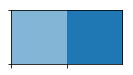

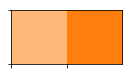

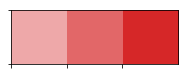

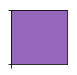

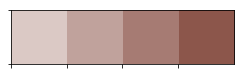

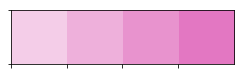

In [70]:
color_dict = {}
start_colors = sns.color_palette(n_colors=len(level1_counts))
for i, topic_lev1 in enumerate(nested_topics):
    if topic_lev1 != 'noise':
        c = start_colors[i] #tuple((np.random.random() for _ in range(3)))
        level2_counts = level1_counts[topic_lev1]
        cmap_sub = sns.light_palette(c, level2_counts+1)[1:]
        sns.palplot(cmap_sub)
        for j, topic_lev2 in enumerate(sorted(nested_topics[topic_lev1])):
            label = topic_lev1
            if topic_lev2 != '':
                label+= ' - ' + topic_lev2
            color_dict[label] = cmap_sub[j]

In [122]:
#color_list = sns.color_palette(n_colors=len(topic_names))
# color_list = sns.color_palette("muted", n_colors=10) + sns.color_palette("dark", n_colors=10)
# color_dict = {label: color_list[i] for i,label in enumerate(topic_names)}
color_dict['noise'] = 'grey'

In [123]:
import matplotlib.colors

def style_row(row):
    topic_id = int(row.name)
    topic_name = row.label
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    attr = 'background-color: {}'.format(color)
    return [attr for v in  row]
df_topics.sort_values(['topic_level1', 'topic_level2']).style.apply(style_row, axis=1)

,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,label
topic_nr,,,,,,,,,,,,,
11,عقد,مالك,اجار,فل,عمل,اذ,ول,اجر,مال,ارض,contracts,estates,contracts - estates
4,خيار,مال,بااع,عقد,ول,قبض,اذ,ثمن,مشتر,بيع,contracts,sales,contracts - sales
10,رجل,نفس,قيم,اذ,قطع,عمد,جنا,قصاص,ول,قتل,criminal law,homicide,criminal law - homicide
3,امام,فل,اهل,قطع,اسلام,اذ,قتل,حد,مسلم,ول,criminal law,punishments,criminal law - punishments
5,ول,ظاهر,عدم,هذ,بخلاف,ام,اذ,فل,ذكر,اول,noise,,noise
12,اذ,ول,مسال,وجه,وهذ,فصل,هذ,احدهم,شافع,ثان,noise,,noise
17,مذهب,خلاف,نص,قاض,مسال,ابو,ذكر,احمد,روا,ول,noise,,noise
18,مصنف,ظاهر,فتح,كذ,وكذ,اول,هذ,بحر,ذكر,اذ,noise,,noise
15,طلق,حنث,ول,حد,يم,اذ,ثلاث,حلف,طالق,طلاق,personal law,divorce,personal law - divorce


In [124]:
def plot_bar_per_book(largest_topics, xmin_col, xmax_col, book_names, topic_names, legend=True):
    book_dict = {b: i for i,b in enumerate(book_names)}

    plt.figure(figsize=(25, np.floor(len(book_names)*0.5)))
    ax = plt.gca()
    for topic_name in sorted(topic_names):
        largest_topics_sub = largest_topics[largest_topics['label']==topic_name]
        #color = color_list[topic] 
        color = color_dict[topic_name]

        y = [book_dict[s] for s in largest_topics_sub['book']]
        #x = largest_topics_sub['chapter']
        xmin = largest_topics_sub[xmin_col]
        xmax = largest_topics_sub[xmax_col]
        if topic_name != 'noise':
            ax.hlines(y, xmin, xmax, #marker='s', edgecolors=None, 
                      colors=np.array((color,)), lw=10,
                       label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
    ax.set_yticks(np.arange(len(book_dict)))
    ax.set_yticklabels(book_names)
    ax.set_xlim(0, largest_topics[xmax_col].max())
    ax.set_ylim(-0.5, len(book_names))
    if legend:
        plt.legend(fontsize='large')
    ax.invert_yaxis()
    #ax.set_facecolor('black')
    plt.show()

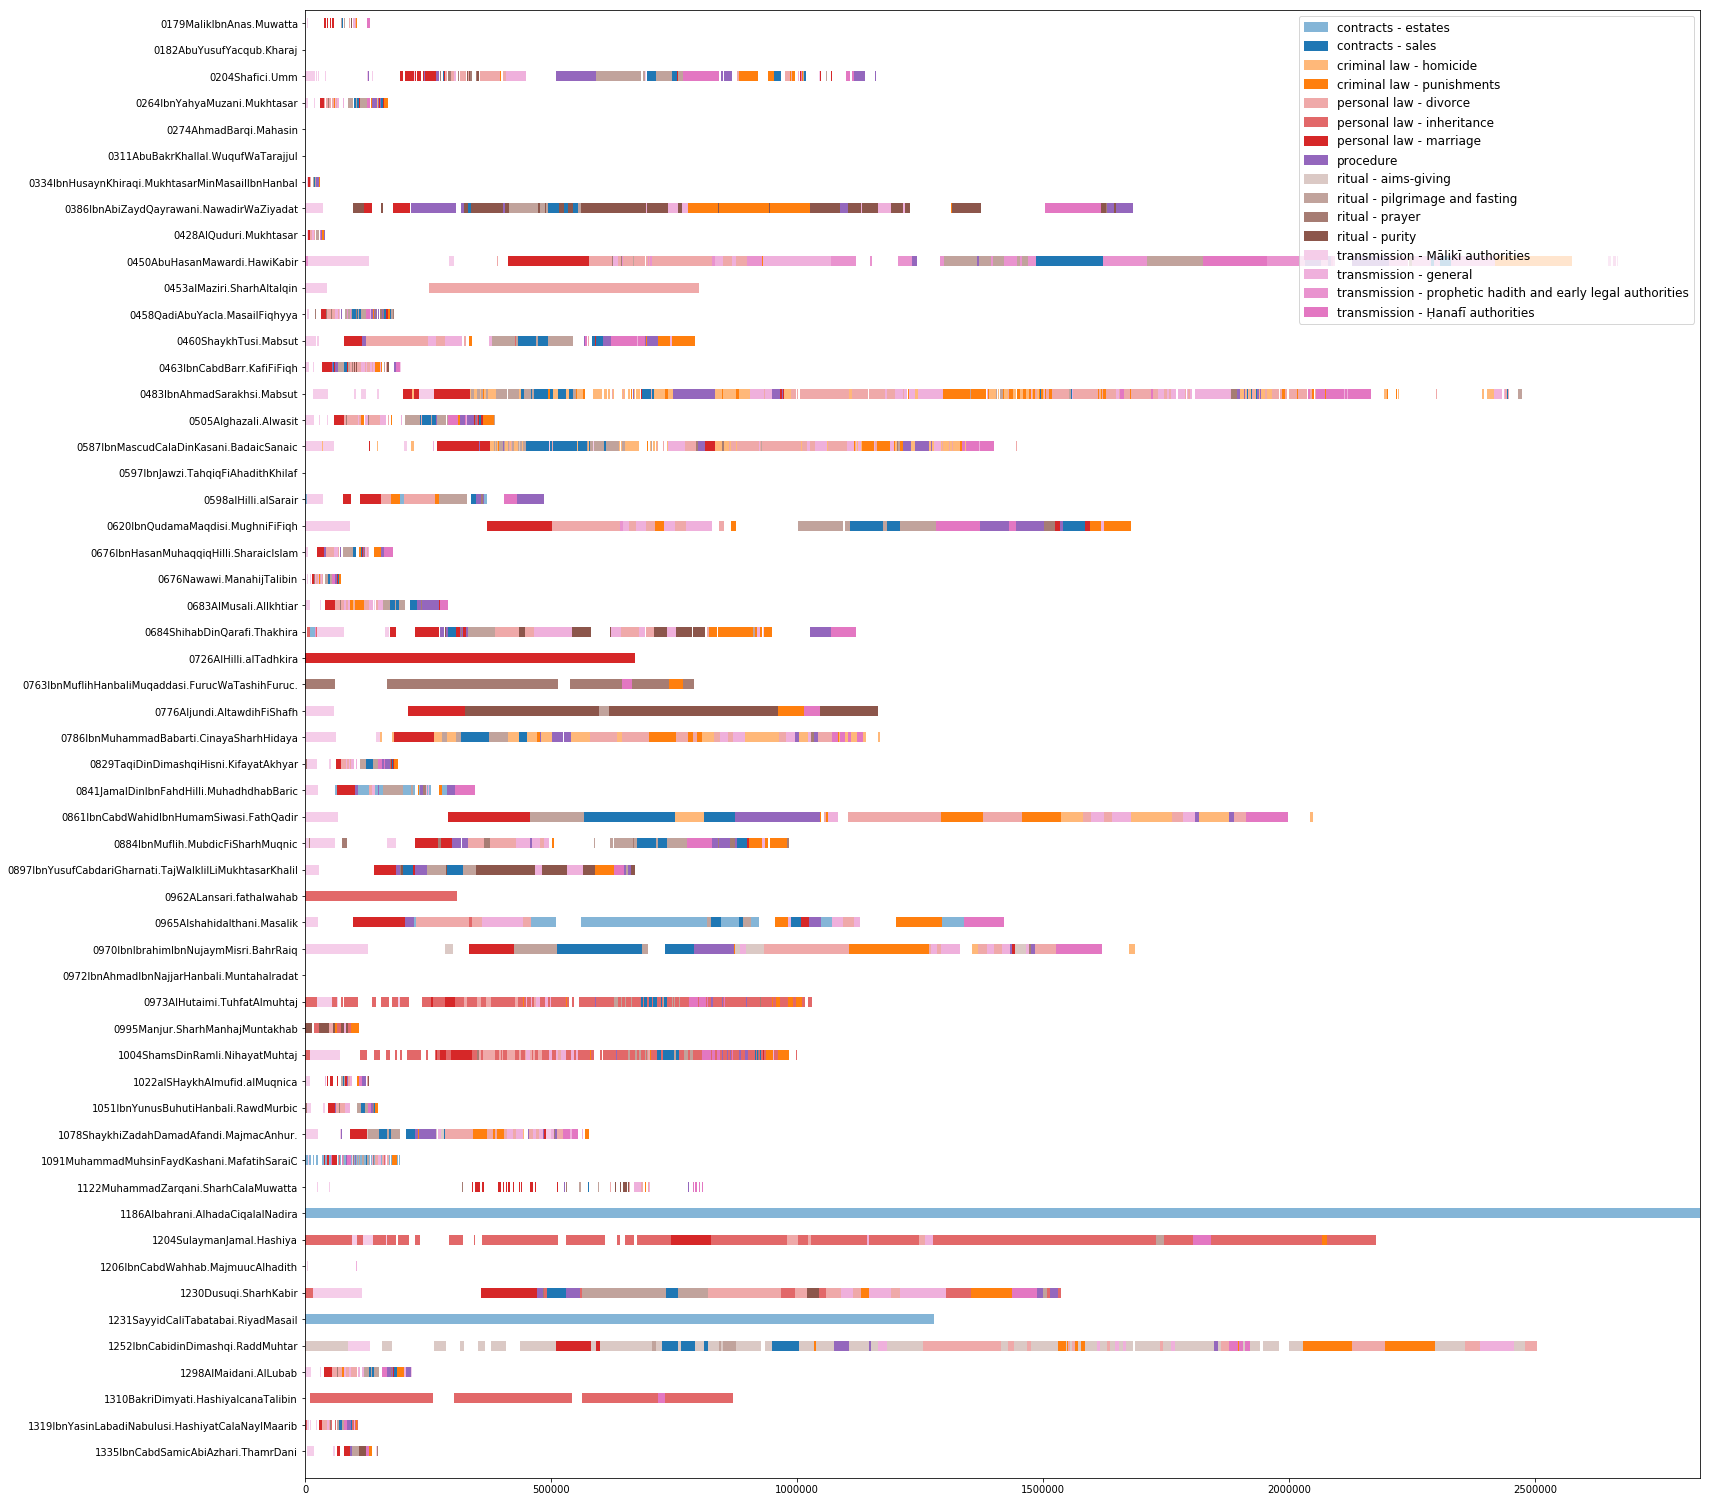

In [125]:
plot_bar_per_book(largest_topics, 'x0', 'x1', book_names, topic_names, legend=True)

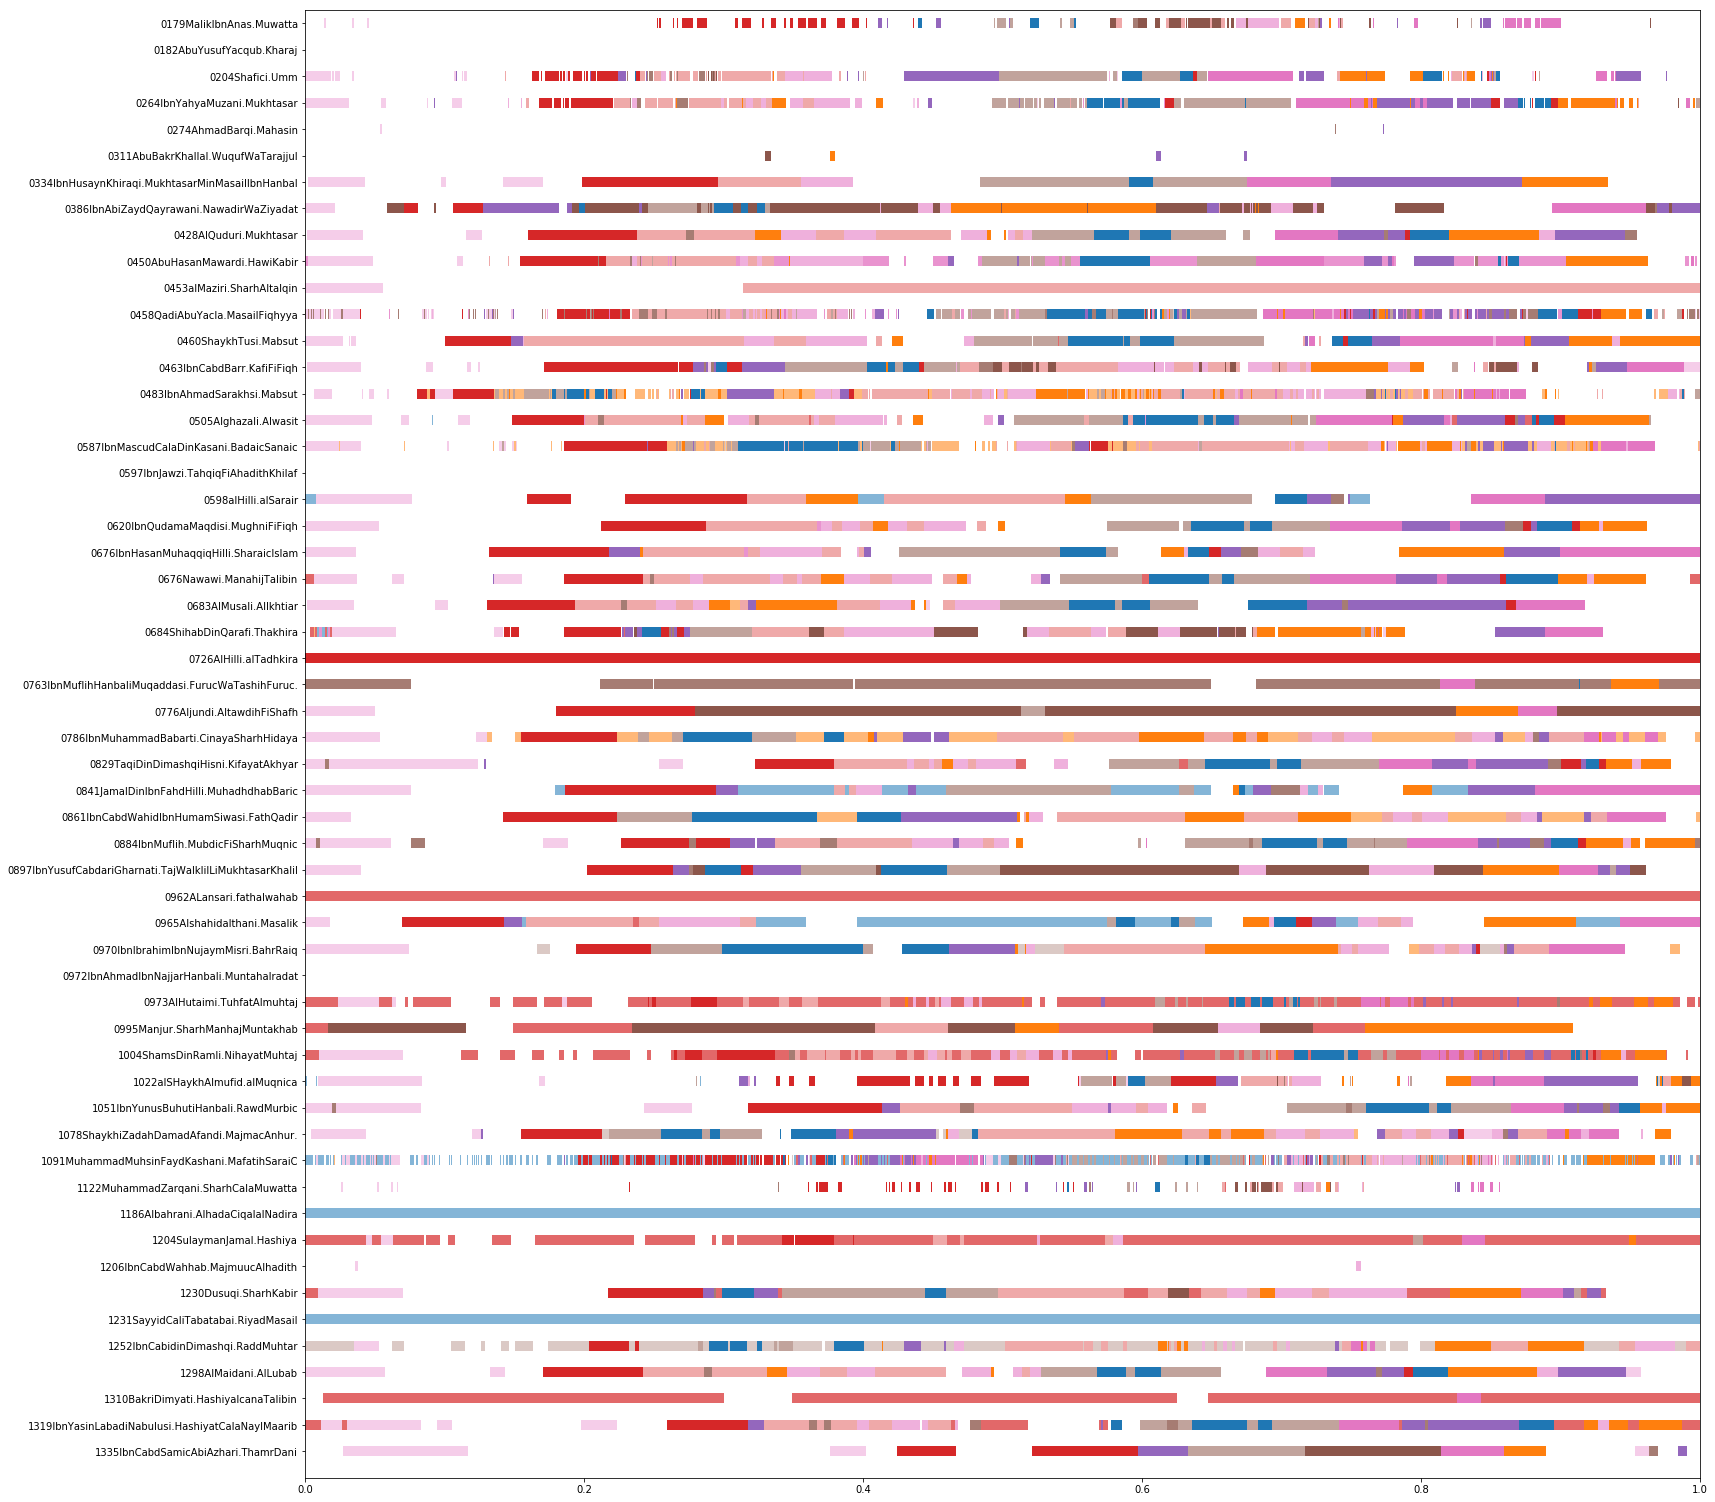

In [75]:
plot_bar_per_book(largest_topics, 'perc0', 'perc1', book_names, topic_names, legend=False)

مالكي


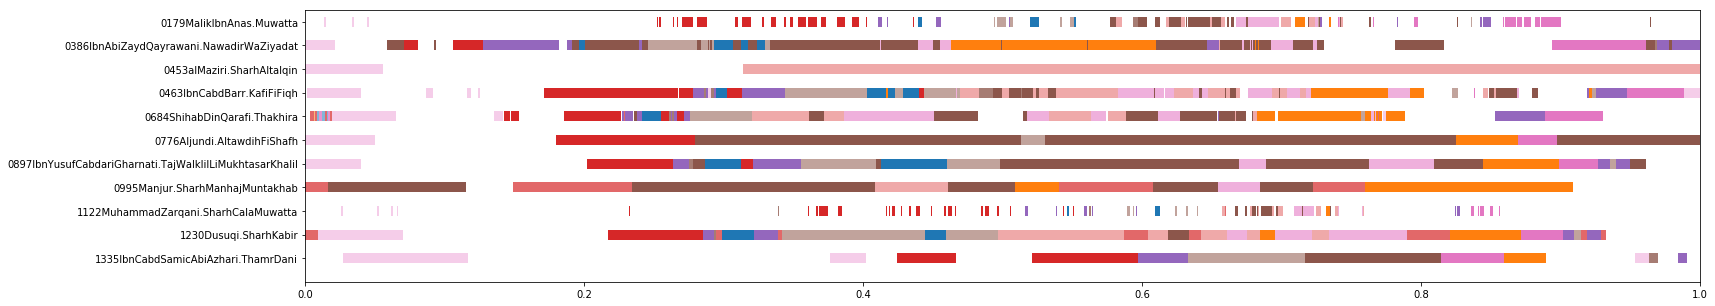

حنفي


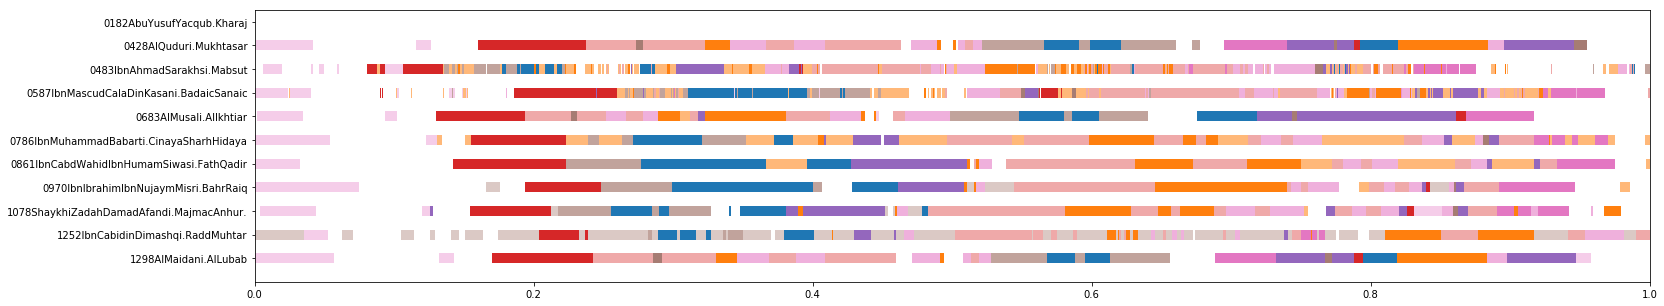

شافعي


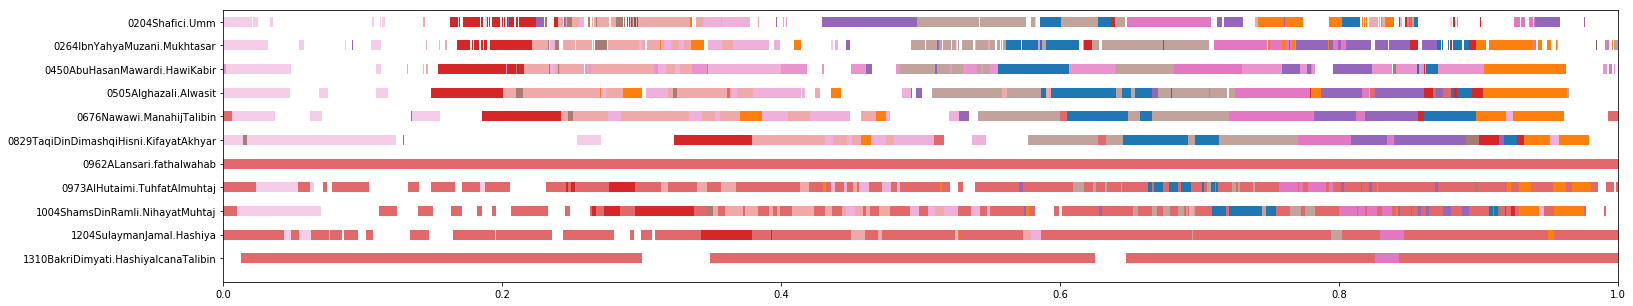

شيعي


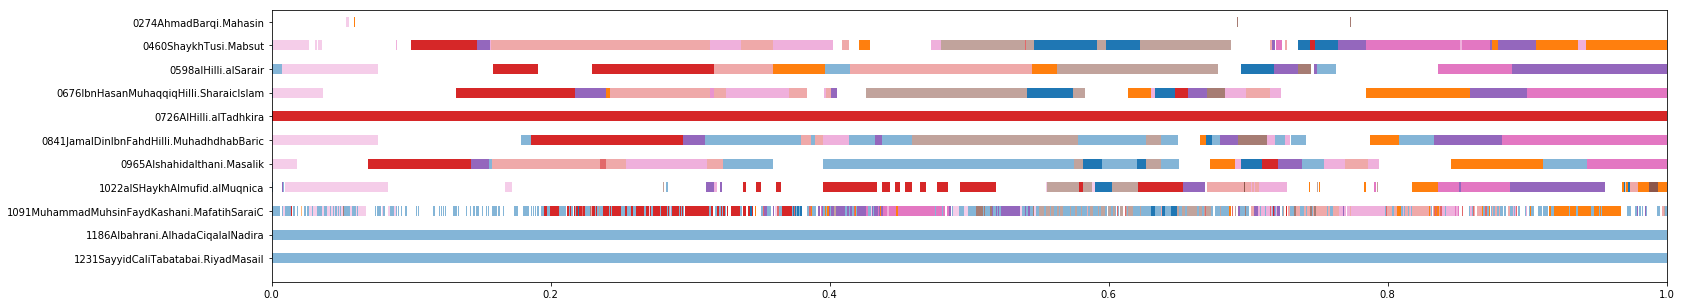

حنبلي


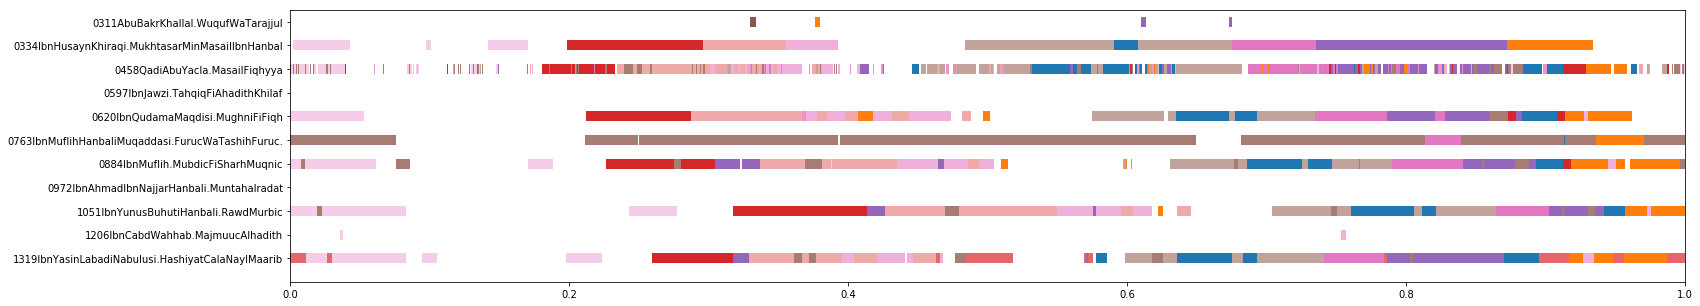

In [76]:
for subj in metadata.BookSUBJ.unique():
    if type(subj)==str:
        print(subj)
        ind_sub = metadata_newind[metadata_newind.BookSUBJ==subj].index.to_frame()
        ind_sub.columns = ['book', 'chapter']
        largest_topics_sub = largest_topics.merge(ind_sub, how='inner')
        plot_bar_per_book(largest_topics_sub, 'perc0', 'perc1', largest_topics_sub.book.unique(), topic_names, legend=False)

In [111]:
def plot_bars_per_topic(df, topic_names, col1, col2='ChapterLength', aggfunc=sum, reshape_col1=False):
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    values = df.groupby([col1, 'topic_name'])[col2].apply(aggfunc).sort_values()
    values = values.unstack().fillna(0)
    values = values.reindex(sorted(values.index), axis=0)
    #sorted_index = values.sum(axis=1).sort_values(ascending=False).index
    #values = values.loc[sorted_index,:]
    ind0 = values.index
    ind1 = values.columns
    x = np.arange(len(ind0))
    last_y = np.repeat(0, len(ind0))
    for t, topic_name in enumerate(ind1):
        y = values[topic_name]
        if topic_name != 'noise':
            ax.bar(x, y, bottom=last_y, color=color_dict[topic_name],
                    label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
            last_y = last_y+y
    if reshape_col1:
        xlabels = [bidi.algorithm.get_display(arabic_reshaper.reshape(l)) for l in ind0]
    else:
        xlabels = ind0
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

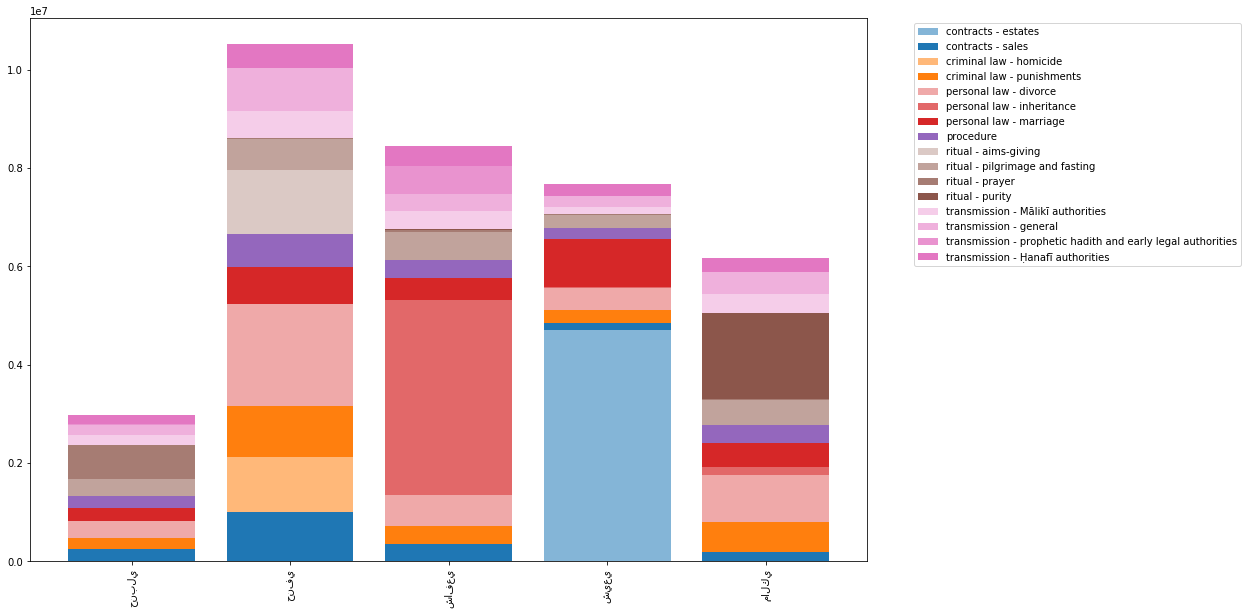

In [112]:
# Here we see the total number of tokens per topic
plot_bars_per_topic(metadata_newind, topic_names, 'BookSUBJ')

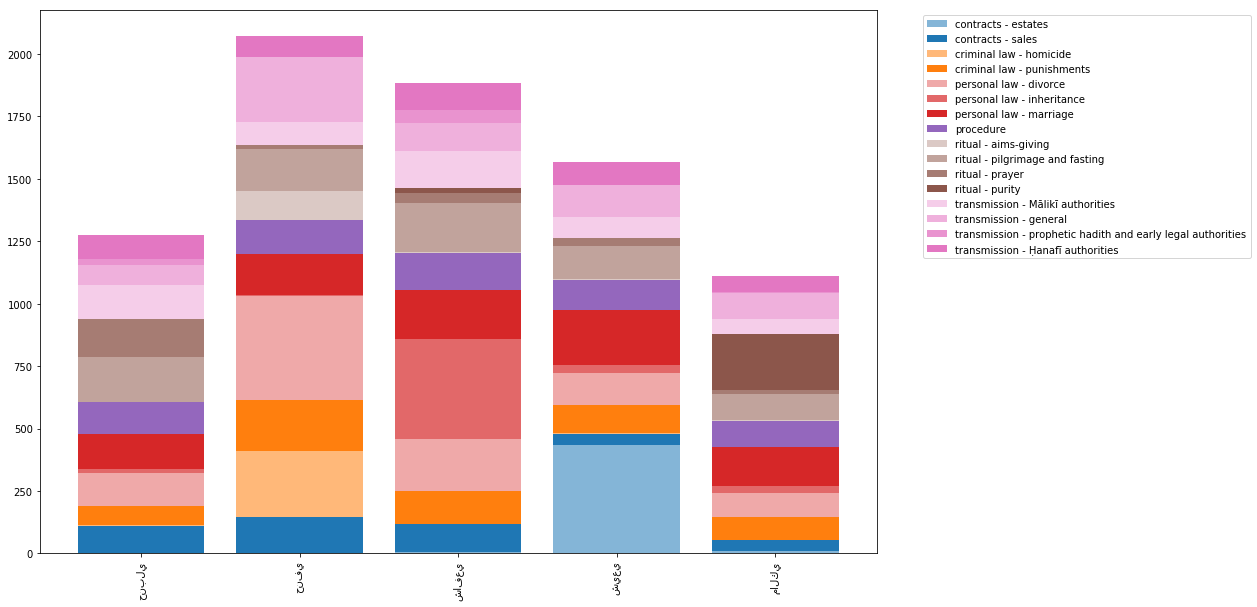

In [113]:
# Here we see only the number of chapters
plot_bars_per_topic(metadata_newind, topic_names, 'BookSUBJ', aggfunc=len)

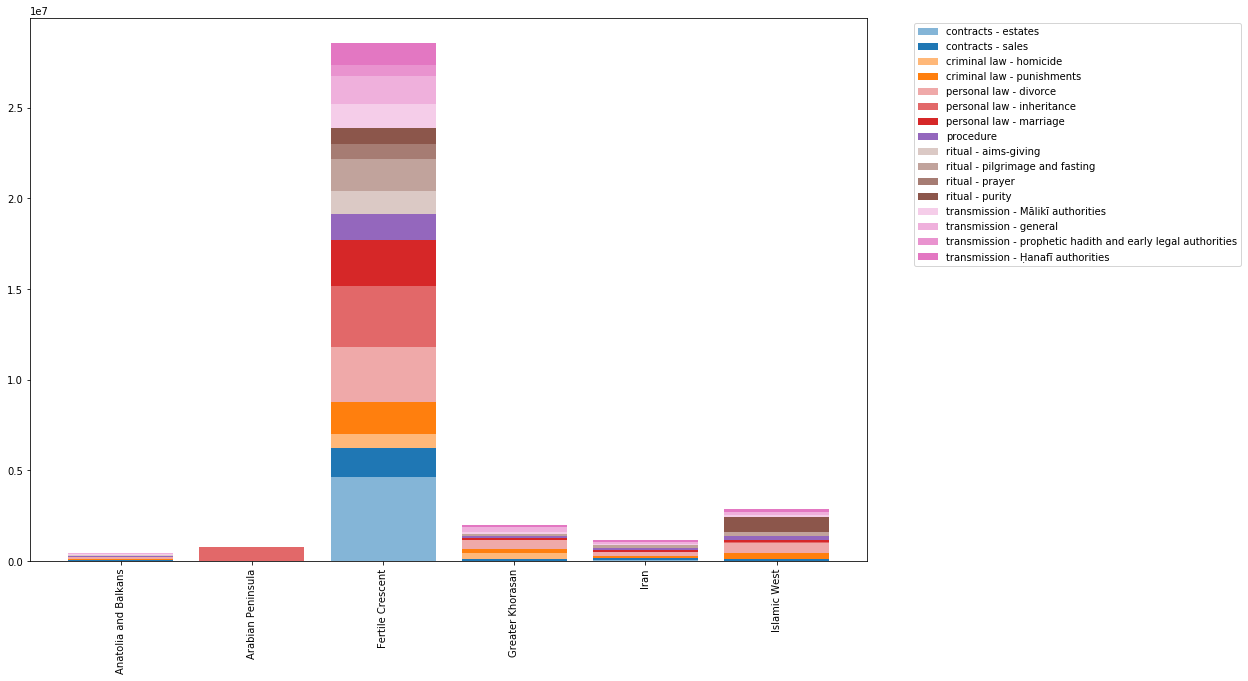

In [114]:
plot_bars_per_topic(metadata_newind, topic_names, 'Author_Geographical_Area')

In [115]:
import re
metadata_newind['Century_num'] = metadata_newind.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

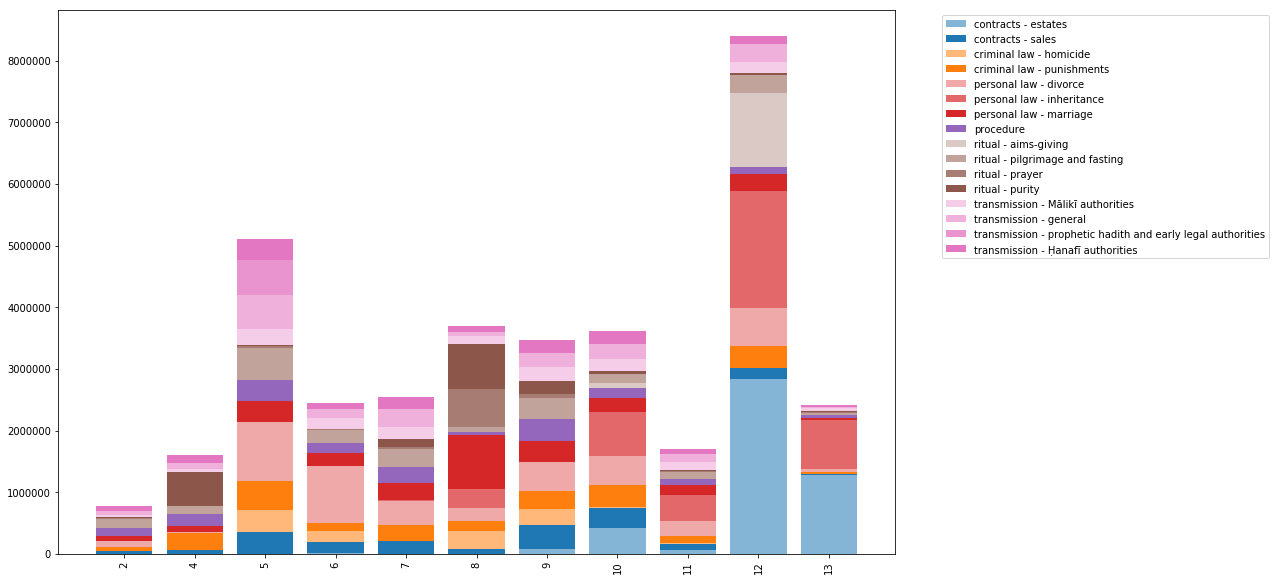

In [116]:
plot_bars_per_topic(metadata_newind, topic_names, 'Century_num')

In [117]:
def style_color(df, color):
    st = 'background-color: {}'.format(color)
    return df.style.apply(lambda r: [st]*len(r))

# Print the most common titles per topic
for t, topic_name in enumerate(topic_names):
    #if topic_name != 'noise':
    meta_sub = metadata_newind[metadata_newind['topic_name']==topic_name]
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    #print(t, topic_name)
    display(style_color(pd.DataFrame([topic_name], index=[t], columns=['label']), color=color))
    print("Volumes:")
    for v in meta_sub.Level1Title.value_counts().head(10).index:
        print(v)
    print("\nChapters:")
    for c in meta_sub.Level2Title.value_counts().head(10).index:
        print(c)
    print('\n')

,label
0,personal law - marriage


Volumes:
كتاب الحج
كتاب مفاتيح الحج
-
كتاب الحج باب فرض الحج على من وجب عليه الحج
كتاب المناسك
كتاب الحج من أحرم بالحج عن غيره وهو لم يحج عن نفسه مسألة اختلف أصحابنا رحمة الله عليهم
كتاب باب إغماض الميت
كتاب الزكاة فصل في حقيقة الزكاة وما يحب فيها وبيان شروطها
كتاب مفاتيح الصلاة فلا نعيده في الصحيح هما واحد إذا قصرت أفطرت إذا أفطرت قصرت
كتاب الصيام

Chapters:
-
باب الاعتكاف
باب الإحصار
مسألة
باب صوم التطوع
باب
باب الهدي
باب الإحرام
باب المواقيت
باب القران




,label
1,ritual - aims-giving


Volumes:
كتاب الطلاق
كتاب النكاح
كتاب الصلاة
كتاب الإقرار
كتاب الحدود
كتاب الزكاة
كتاب العتق
كتاب الوصايا
كتاب الوقف
كتاب القضاء

Chapters:
باب البغاة
-
باب موت المكاتب وعجزه وموت المولى
باب ما يبطلها
باب الاستبراء وغيره
باب المضارب يضارب
باب القسامة
باب إقرار المريض
باب التعزير
باب الهدي




,label
2,ritual - prayer


Volumes:
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب البيوع وما يتعلق به من العقود بيع من غير رؤية المبيع ولا وصفه مسألة واختلفت الرواية عن
كتاب البيوع
كتاب السير
كتاب مفاتيح المطاعم المشارب
-
كتاب الأطعمة
كتاب الأشربة
كتاب البيع
كتاب الزكاة مسائل في حكم مانع الزكاة من امتنع عن إخراج الزكاة بخلا وقاتل عليها مسألة واختلفت

Chapters:
-
مسألة
باب الربا
باب الذكاة
باب الآنية
باب الربا والصرف
مسألة واختلفت
باب بيع اللحم باللحم
باب السلم
باب حكم المرتد




,label
3,criminal law - punishments


Volumes:
كتاب الشهادات
كتاب الدعوى
كتاب مفاتيح القضاء الشهادات
كتاب باب إغماض الميت
كتاب القضاء
كتاب الإقرار
كتاب القاضي إلى القاضي
-
كتاب الأقضية
كتاب الأيمان والنذور والكفارات

Chapters:
-
باب الرجوع عن الشهادة
باب حد القذف
باب الصرف
باب
باب الشهادة على الشهادة
باب كتاب القاضي إلى القاضي
باب دعوى النسب
الشهادة على الشهادة قال الشهادة على الشهادة جائزة في كل حق
باب أدب القاضي




,label
4,contracts - sales


Volumes:
كتاب الطلاق
كتاب الأيمان
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
كتاب باب إغماض الميت
-
كتاب الأيمان والنذور والكفارات
كتاب الظهار
كتاب الطلاق باب حكم الطلاق وسنته
كتاب الخلع سمى الله تعالى الخلع في كتابه افتداء فقال فلا جناح
كتاب الإيلاء

Chapters:
-
باب الخلع
باب الشك في الطلاق
باب الإيلاء
باب الظهار
باب
باب السلم
مسألة
باب الرجعة
بابجامع لمسائل مختلفة في




,label
5,noise


Volumes:
-
كتاب الصلاة
كتاب الزكاة
كتاب باب إغماض الميت
كتاب الفرائض
كتاب العتق
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب
كتاب الوصايا
كتاب مفاتيح الصلاة

Chapters:
-
باب
باب ما جاء في
باب ما
باب صلاة العيدين
باب صلاة الجمعة
مسألة
باب السبق باب السبق وللبخاري عن ابن عمر قال أجرى النبي صلى الله عليه وسلم
باب صلاة الخوف
باب القرض باب القرض وعن عبد الله بن أبي ربيعة أن النبي صلى الله عليه وسلم




,label
6,ritual - purity


Volumes:
كتاب الصرف في
كتاب البيوع
كتاب
كتاب البيوع باب ما جاء في بيع
كتاب البيوع باب
كتاب التفليس
كتاب الطلاق باب حكم الطلاق وسنته
كتاب العارية في ضمان
فصل
كتاب الوكالات والبضائع بابفيمن وكل على طلب عبد أو ربع ولم

Chapters:
-
بابفي
باب
الباب الرابع في النزاع
بابفي تفليس
بابآخر من رد
بابجامع لمسائل مختلفة في
بابفي الإكراه على التخيير قال ابن سحنون
الباب الثاني في الطوارئ على المغصوب من نقصان وزيادة وتصريف
بابجامع لمعاني مختلفة من مسائل الهبات والصدقات من العتبية روى أشهب عن مالك




,label
7,transmission - prophetic hadith and early legal authorities


Volumes:
كتاب الوكالة
كتاب مختصر الجامع من كتاب الجزية وما دخل فيه من اختلاف الأحاديث
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
-
كتاب الجمعة وغيرها من أمرها
كتاب الأقضية واليمين مع الشاهد وما دخل فيه من اختلاف الحديث وغير
كتاب السير
كتاب باب إغماض الميت
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب الوديعة وقسم الفيء والغنيمة

Chapters:
-
بابتداء الجناية ديتين وما
بابه فقال من هذه فقالت
باب جامع الأيمان الثاني
باب قتل المحرم الصيد عمدا أو خطأ
باب نشوز المرأة على الرجل من الجامع من كتاب نشوز الرجل على المرأة
باب الإطعام في الكفارة في البلدان كلها ومن له أن يطعم وغيره
باب الإحصان الذي به يرجم من زنى من كتاب التعريض بالخطبة وغير ذلك
مسألة هل
مسألة إذا دفع الزكاة إلى من




,label
8,transmission - general


Volumes:
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب المزارعة
كتاب المضاربة
كتاب الإجارة
كتاب القسمة
كتاب العارية
كتاب الغصب
كتاب باب إغماض الميت
كتاب الشركة
كتاب الإجارات

Chapters:
-
باب الرجوع عن الشهادة
باب السلم
باب الصرف
باب الضمان شرط الضامن الرشد
باب القسمة
باب الإجارة
باب الشركة
بابفي إحياء الموات من الأرض وشيء من ذكر القطائع من المجموعة وكتاب ابن حبيب روى ابن وهب
باب الجعالة




,label
9,transmission - Ḥanafī authorities


Volumes:
كتاب الجراح
كتاب مفاتيح الحسبة الحدود
كتاب الجنايات
كتاب الديات
كتاب باب إغماض الميت
-
تاب الديات
كتاب العقول
كتاب العقول باب ذكر العقول
كتاب الرد على محمد بن الحسن باب الديات

Chapters:
-
باب القسامة
باب
باب ميراث القاتل
باب الاستيلاد
باب جناية المكاتب في الخطأ
باب العفو عن القصاص
باب ما يوجب القصاص فيما دون النفس
القسامة لما كان أمر القتيل في بعض الأحوال يئول
باب ما جاء في عقل




,label
10,criminal law - homicide


Volumes:
كتاب النكاح
كتاب الدعوى
-
كتاب الإكراه
كتاب العتاق
كتاب المكاتب
كتاب الحدود
كتاب المأذون
كتاب الطلاق
كتاب النفقة

Chapters:
-
من يكاتب عن العبد لما فرغ من ذكر أحكام تتعلق
فصل وأما شرائط الركن فأنواع
باب الرجل يرى الرجل يقتل أباه
باب الصيد في الحرم
فصل وأما بيان ما تبطل به الوصية
باب اللعان الذي يقضي به القاضي ثم يتبين أنه باطل
فصل وأما الذي يرجع إليهما جميعا فواحد
دعوى النسب لما فرغ من بيان دعوى الأموال شرع في
باب الإقرار بعد قسم الميراث




,label
11,contracts - estates


Volumes:
كتاب مفاتيح الصلاة
كتاب مفاتيح المناكح المواليد
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب مفاتيح الحسبة الحدود
كتاب مفاتيح الحج
كتاب مفاتيح الزكاة
كتاب مفاتيح العطايا المروات
كتاب مفاتيح الصلاة فلا نعيده في الصحيح هما واحد إذا قصرت أفطرت إذا أفطرت قصرت
-
كتاب مفاتيح المطاعم المشارب

Chapters:
-
مفتاح قضاء الحقوق الواجبة المالية
مفتاح أحكام الوضوء
مفتاح ما لو اشترك جماعة في الصيد
مفتاح حكم الشرط في العقد
مفتاح ولاء ضامن الجريرة حكم من فقده
مفتاح ما يشترط في صيغة الطلاق
مفتاح وجوب الأمر بالمعروف النهي عن المنكر كفائي عيني
مفتاح ولاية النكاح على من هي
مفتاح ما يشرط في الرقبة المعتقة




,label
12,noise


Volumes:
-
كتاب الصلاة
كتاب الزكاة
كتاب باب إغماض الميت
كتاب الفرائض
كتاب العتق
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب
كتاب الوصايا
كتاب مفاتيح الصلاة

Chapters:
-
باب
باب ما جاء في
باب ما
باب صلاة العيدين
باب صلاة الجمعة
مسألة
باب السبق باب السبق وللبخاري عن ابن عمر قال أجرى النبي صلى الله عليه وسلم
باب صلاة الخوف
باب القرض باب القرض وعن عبد الله بن أبي ربيعة أن النبي صلى الله عليه وسلم




,label
13,transmission - Mālikī authorities


Volumes:
-
كتاب الطهارة
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب مفاتيح الصلاة
كتاب الصلاة
كتاب الطهارة باب ما يوجب الوضوء من
كتاب الطهارة قوله وهي رفع الحدث الأولى أن يقول
كتاب نوادر الصوم
كتاب الحيض
كتاب الجنائز

Chapters:
-
باب التيمم
باب المسح على الخفين
باب الحيض
مسألة
باب المستحاضة
باب الشهيد
باب الغسل
باب إزالة النجاسة
باب السواك




,label
14,personal law - inheritance


Volumes:
كتاب النكاح
-
كتاب الصلاة
كتاب
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب الحج
كتاب الصلاة هي شرعا
كتاب صلاة الجماعة وأحكامها
كتاب الرهن
كتاب الوقف

Chapters:
-
فصل في
باب دعوى الدم
بابا عن غير مميز كطير وعبد مجنون وهذا أعم وأولى من قوله ولو فتح قفصا
فصل في شروط الإمام الأعظم وبيان طرق الإمامة هي فرض كفاية كالقضاء فيأتي فيها أقسامه
فصلفي شروط الإمام الأعظم وبيان طرق الإمامة
فصل فيما يترتب على الظهار من حرمة نحو وطء ولزوم كفارة وغير ذلك يجب على المظاهر كفارة إذا عاد
فصلفي الإيصاء
فصلفي العقيقة
فصلفي بيان النظر على الوقف وشرطه ووظيفة الناظر




,label
15,personal law - divorce


Volumes:
كتاب البيوع
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب البيع
كتاب الرهن
كتاب الوكالة
كتاب الشفعة
كتاب الكفالة
كتاب البيوع وما يتعلق به من العقود بيع من غير رؤية المبيع ولا وصفه مسألة واختلفت الرواية عن
-
كتاب باب إغماض الميت

Chapters:
-
باب السلم
باب الصرف
باب
باب الرجوع عن الشهادة
باب الحوالة
باب الصلح
فصل وأما الشرائط فأنواع
باب الضمان
باب الإقالة




,label
16,procedure


Volumes:
كتاب الحدود
كتاب السير
كتاب باب إغماض الميت
كتاب الجهاد
-
كتاب مفاتيح الحسبة الحدود
كتاب الجهاد باب واجب الجهاد ونافلته
كتاب مفاتيح المطاعم المشارب
كتاب الصيد والذبائح
كتاب السرقة

Chapters:
-
باب حد القذف
باب حد الشرب
مسألة
باب موجبات الدية والعاقلة والكفارة
فصل في حكم الساحر إذا قتل بسحره السحر له حقيقة عند قوم وهو أن
باب قطع الطريق
باب حكم المرتد
الباب الثاني في الاضطرار
باب الحال التي لا يحل فيها دماء أهل البغي




,label
17,noise


Volumes:
-
كتاب الصلاة
كتاب الزكاة
كتاب باب إغماض الميت
كتاب الفرائض
كتاب العتق
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب
كتاب الوصايا
كتاب مفاتيح الصلاة

Chapters:
-
باب
باب ما جاء في
باب ما
باب صلاة العيدين
باب صلاة الجمعة
مسألة
باب السبق باب السبق وللبخاري عن ابن عمر قال أجرى النبي صلى الله عليه وسلم
باب صلاة الخوف
باب القرض باب القرض وعن عبد الله بن أبي ربيعة أن النبي صلى الله عليه وسلم




,label
18,noise


Volumes:
-
كتاب الصلاة
كتاب الزكاة
كتاب باب إغماض الميت
كتاب الفرائض
كتاب العتق
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب
كتاب الوصايا
كتاب مفاتيح الصلاة

Chapters:
-
باب
باب ما جاء في
باب ما
باب صلاة العيدين
باب صلاة الجمعة
مسألة
باب السبق باب السبق وللبخاري عن ابن عمر قال أجرى النبي صلى الله عليه وسلم
باب صلاة الخوف
باب القرض باب القرض وعن عبد الله بن أبي ربيعة أن النبي صلى الله عليه وسلم




,label
19,ritual - pilgrimage and fasting


Volumes:
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
كتاب النكاح
كتاب مفاتيح المناكح المواليد
كتاب باب إغماض الميت
كتاب الطلاق
-
كتاب النفقات
كتاب الوكالة
كتاب الرضاع
كتاب النكاح باب السنة في عقد

Chapters:
-
باب الرجعة
باب اللعان
باب الاستبراء
باب الخيار والاعفاف ونكاح العبد وجد أحد زوجين
باب السلم
باب
باب العدة
باب الحضانة
باب التعريض بالخطبة




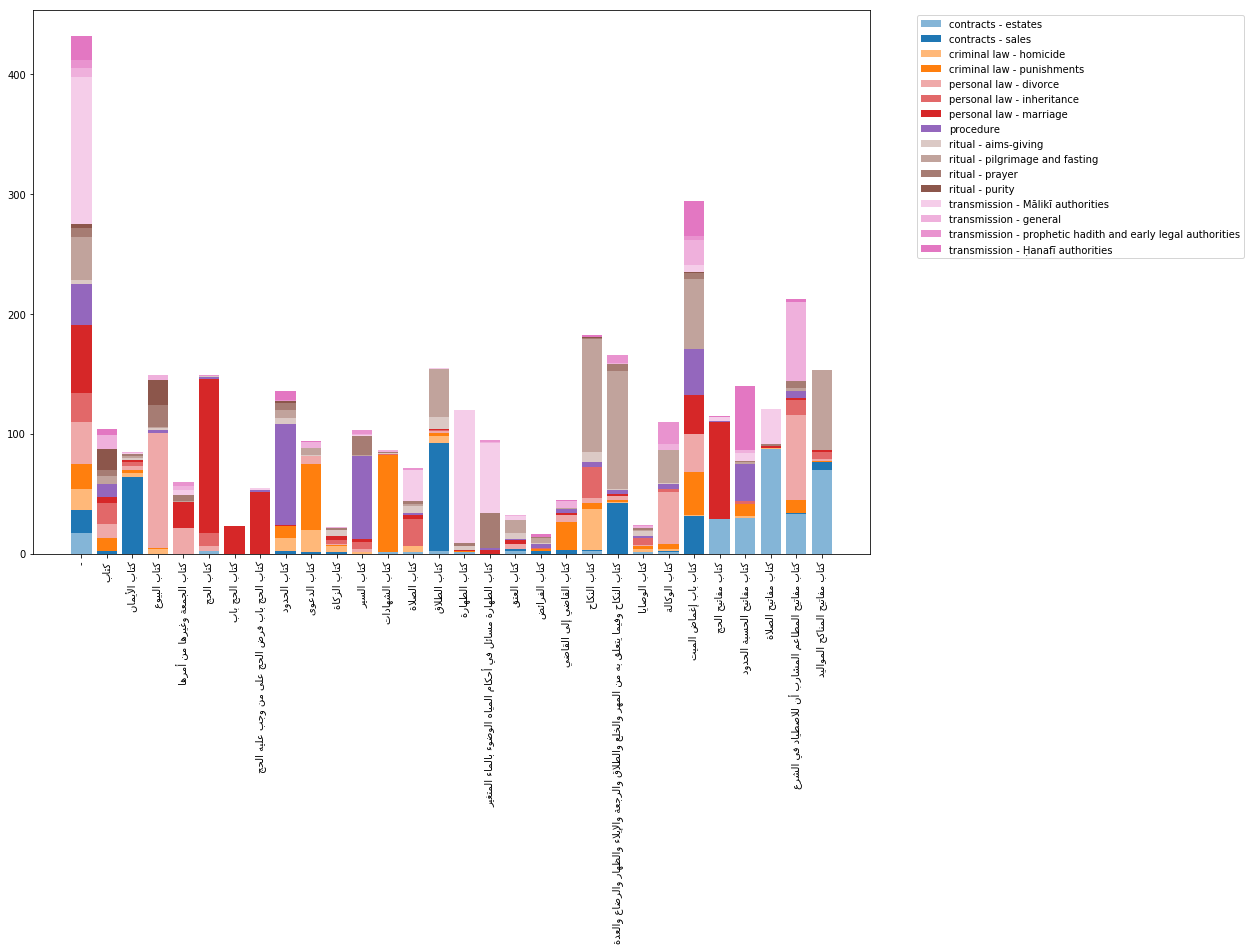

In [120]:
# The 30 most common volume names
voltitles = metadata_newind['Level1Title'].value_counts().head(30).index
meta_sub = metadata_newind[metadata_newind.Level1Title.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'Level1Title', reshape_col1=True, aggfunc=len)

0 باب
1 مسألة
2 باب السلم
3 باب الرجوع عن الشهادة
4 باب الصرف
5 باب حد القذف
6 باب ما
7 باب ما جاء في
8 باب الاستيلاد
9 باب البغاة
10 باب الاعتكاف
11 باب القسامة
12 بابفي
13 باب الضمان شرط الضامن الرشد
14 فصل في
15 باب اللقطة
16 باب التيمم
17 باب القسمة
18 باب حد الشرب
19 مسألة إذا
20 باب صلاة العيدين
21 باب الخيار والاعفاف ونكاح العبد وجد أحد زوجين
22 باب الحيض
23 باب المسح على الخفين
24 باب الرجعة
25 دعوى الغلط في القسمة
26 باب صدقة الفطر
27 باب الهدي
28 باب الخلع


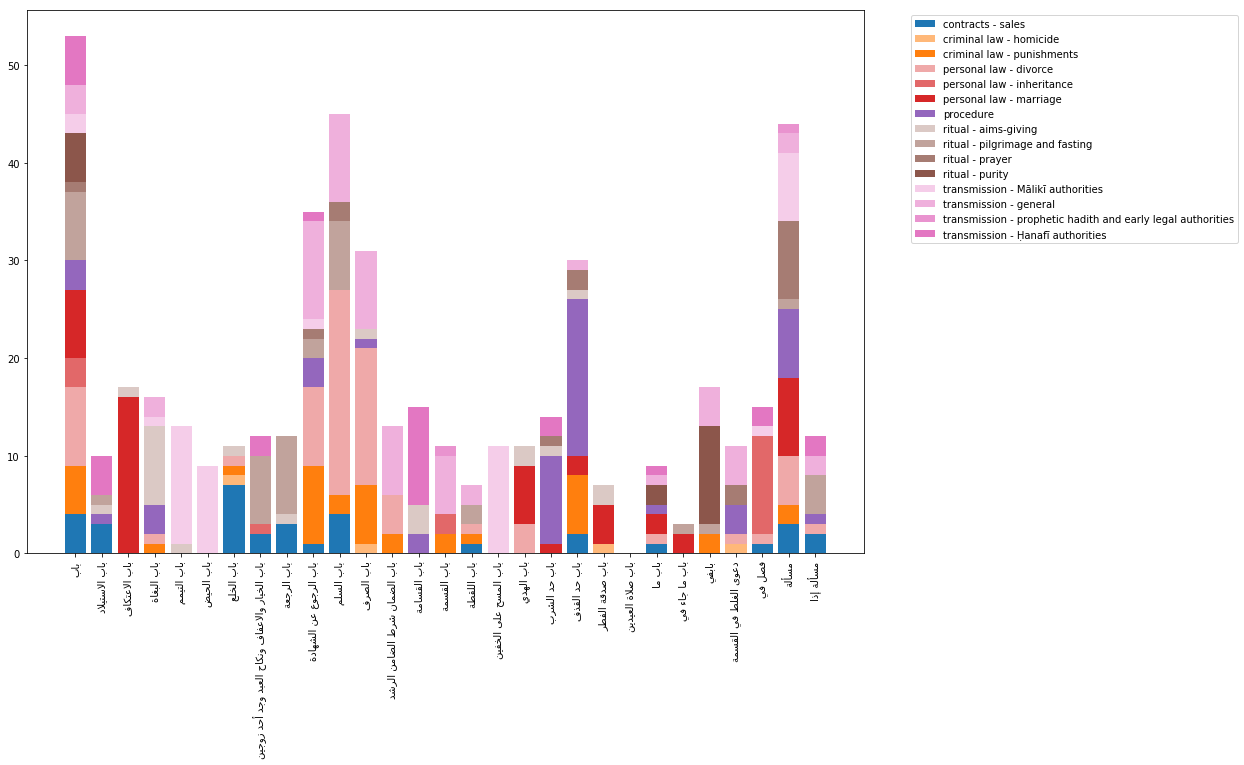

In [121]:
# The 30 most common chapter names
voltitles = metadata_newind['Level2Title'].value_counts().head(30)[1:].index
for i, v in enumerate(voltitles):
    print(i, v)
meta_sub = metadata_newind[metadata_newind.Level2Title.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'Level2Title', reshape_col1=True, aggfunc=len)